Step 1: Load data...
Step 2: Training...
Iteration count:1. Entire set, alpha pairs changed times:0
Congratulations! Training complete! Took 0.252785s!
step 3: testing...
step 4: show the result...
The classify accuracy is: 100.000%
The classify recall is: 1.923%
The classify presision is: 50.000%
The classify f1_score is: 3.704


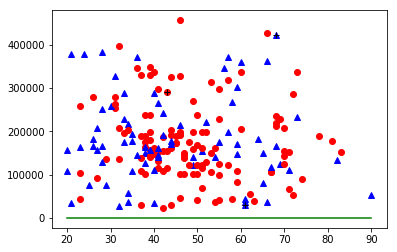

In [90]:
import numpy as np
import time
import matplotlib.pyplot as plt

# 定义一个SVM的类来存放各种数值、条件
class SVM:
    def __init__(self, dataSet, labels, C, terminationCondition, kernelType):
        # x表示数据，y表示类别
        self.data = dataSet
        self.labels = labels
        # 权重
        self.C = C
        # 迭代终止条件
        self.terminationCondition = terminationCondition
        # 样本容量
        self.numberOfSamples = dataSet.shape[0]
        # 拉格朗日乘子
        self.alphas = np.mat(np.zeros((self.numberOfSamples, 1)))
        # 截距
        self.b = 0
        # 误差缓存
        self.errorCache = np.mat(np.zeros((self.numberOfSamples, 2)))
        # 核函数的选择
        self.kernelType = kernelType
        # 存储核函数值的矩阵
        self.kernelMatrix = calculateKernelMatrix(self.data, self.kernelType)

# 计算核函数的值
def calculateKernelValue(matrix_x, sample_x, kernelType):
    # 获取核函数类型
    kernelType = kernelType[0]
    # 获取样本容量
    numberOfSamples = matrix_x.shape[0]
    # 存储核函数的值
    kernelValue = np.mat(np.zeros((numberOfSamples, 1)))
    # 不同的核函数采用不同的计算方法
    # Linear核
    if kernelType == 'Linear':
        kernelValue = matrix_x * sample_x.T
    # RBF核
    elif kernelType == 'RBF':
        sigma = kernelType[1]
        if sigma == 0:
            sigma = 1.0
        for i in range(numberOfSamples):
            kernelValue[i] = np.exp((matrix_x[i, :] - sample_x) * (matrix_x[i, :] - sample_x).T / (- 2.0))
    return kernelValue

# 计算核函数矩阵
def calculateKernelMatrix(data, kernelType):
    # 获取样本容量
    numberOfSamples = data.shape[0]
    # 存储核函数值的矩阵
    kernelMatrix = np.mat(np.zeros((numberOfSamples, numberOfSamples)))
    for i in range(numberOfSamples):
        kernelMatrix[:, i] = calculateKernelValue(data, data[i, :], kernelType)
    return kernelMatrix

# 计算alpha_k的误差
def calculateError(svm, alpha_k):
    error_k = float(np.multiply(svm.alphas, svm.labels).T * svm.kernelMatrix[:, alpha_k] + svm.b - svm.labels[alpha_k])
    return error_k

# 在对alpha_k进行优化后更新alpha_k
def updateError(svm, alpha_k):
    error = calculateError(svm, alpha_k)
    svm.errorCache[alpha_k] = [1, error]

# 选择最大步的alpha j
def selectAlpha_j(svm, alpha_i, error_i):
    # 标为违反（已被优化）
    svm.errorCache[alpha_i] = [1, error_i]
    candidateAlphaList = np.nonzero(svm.errorCache[:, 0].A)[0]
    maxStep = 0; alpha_j = 0; error_j = 0
    # 用最大迭代搜索alpha
    if len(candidateAlphaList) > 1:
        for alpha_k in candidateAlphaList:
            if alpha_k == alpha_i:
                continue
            error_k = calculateError(svm, alpha_k)
            if abs(error_k - error_i) > maxStep:
                maxStep = abs(error_k - error_i)
                alpha_j = alpha_k
                error_j = error_k
    # 若首次运行，则随机选择alpha_j
    else:
        alpha_j = alpha_i
        while alpha_j == alpha_i:
            alpha_j = int(np.random.uniform(0, svm.numberOfSamples))
        error_j = calculateError(svm, alpha_j)
    return alpha_j, error_j

# 优化alpha_i和alpha_j
def loop(svm, alpha_i):
    # 计算alpha_i的误差
    error_i = calculateError(svm, alpha_i)
    # 查找并选取违反KKT条件的alpha
    # 满足KKT条件：
    # 1) alpha == 0，yi*f(i) >= 1 边界外
    # 2) 0<alpha< C，yi*f(i) == 1 边界上
    # 3) alpha == C，yi*f(i) <= 1 边界内
    # 违反KKT条件：
    # 因为 y[i]*Ei = y[i]*f(i) - y[i]^2 = y[i]*f(i) - 1, 因此
    # 1) if y[i]*Ei < 0, so yi*f(i) < 1, if alpha < C, 违反!(若alpha = C则正确)
    # 2) if y[i]*Ei > 0, so yi*f(i) > 1, if alpha > 0, 违反!(若alpha = 0则正确)
    # 3) if y[i]*Ei = 0, so yi*f(i) = 1, 边界上无需优化
    if (svm.labels[alpha_i] * error_i < -svm.terminationCondition) and \
        (svm.alphas[alpha_i] < svm.C) or \
        (svm.labels[alpha_i] * error_i > svm.terminationCondition) and \
        (svm.alphas[alpha_i] > 0):
        # 选择alpha_j
        alpha_j, error_j = selectAlpha_j(svm, alpha_i, error_i)
        alpha_i_old = svm.alphas[alpha_i].copy()
        alpha_j_old = svm.alphas[alpha_j].copy()
        # 计算alpha_j的边界L和H
        if svm.labels[alpha_i] != svm.labels[alpha_j]:
            L = max(0, svm.alphas[alpha_j] - svm.alphas[alpha_i])
            H = min(svm.C, svm.C + svm.alphas[alpha_j] - svm.alphas[alpha_i])
        else:
            L = max(0, svm.alphas[alpha_j] + svm.alphas[alpha_i] - svm.C)
            H = min(svm.C, svm.alphas[alpha_j] + svm.alphas[alpha_i])
        if L == H:
            return 0
        # 计算eta（样本i和样本j的相似度）
        eta = 2.0 * svm.kernelMatrix[alpha_i, alpha_j] - \
              svm.kernelMatrix[alpha_i, alpha_i] - svm.kernelMatrix[alpha_j, alpha_j]
        if eta >= 0:
            return 0
        # 更新alpha_j
        svm.alphas[alpha_j] -= svm.labels[alpha_j] * (error_i - error_j) / eta
        # 裁剪alpha_j
        if svm.alphas[alpha_j] > H:
            svm.alphas[alpha_j] = H
        if svm.alphas[alpha_j] < L:
            svm.alphas[alpha_j] = L
        # 如果alpha_j变化不大则不更新误差
        if abs(alpha_j_old - svm.alphas[alpha_j]) < 0.00001:
            updateError(svm, alpha_j)
            return 0
        # 优化alpha_j后更新alpha_i
        svm.alphas[alpha_i] += svm.labels[alpha_i] * svm.labels[alpha_j] * (alpha_j_old - svm.alphas[alpha_j])
        # 更新截距b
        b1 = svm.b - error_i - svm.labels[alpha_i] * (svm.alphas[alpha_i] -
            alpha_i_old)  * svm.kernelMatrix[alpha_i, alpha_i] - \
             svm.labels[alpha_j] * (svm.alphas[alpha_j] - alpha_j_old)  * svm.kernelMatrix[alpha_i, alpha_j]
        b2 = svm.b - error_j - svm.labels[alpha_i] * (svm.alphas[alpha_i] -
            alpha_i_old) * svm.kernelMatrix[alpha_i, alpha_j] - \
             svm.labels[alpha_j] * (svm.alphas[alpha_j] - alpha_j_old) * svm.kernelMatrix[alpha_j, alpha_j]
        if (0 < svm.alphas[alpha_i]) and (svm.alphas[alpha_i] < svm.C):
            svm.b = b1
        elif (0 < svm.alphas[alpha_j]) and (svm.alphas[alpha_j] < svm.C):
            svm.b = b2
        else:
            svm.b = (b1 + b2) / 2.0
        # 优化alpha_i，alpha_j和b后，更新alpha_i和alpha_j的误差
        updateError(svm, alpha_j)
        updateError(svm, alpha_i)
        return 1
    else:
        return 0

# SVM训练算法，核函数默认为RBF核
def train(train_x, train_y, C, terminationCondition, maxIteration, kernelType = ('RBF', 1.0)):
    # 计算训练时长
    startTime = time.time()
    # 初始化SVM类
    svm = SVM(train_x, train_y, C, terminationCondition, kernelType)
    # 是否遍历整个样本集
    entireSet = True
    # alpha对改变次数
    alphaPairsChangedCount = 0
    # 统计迭代次数
    iterationCount = 0
    # 当达到最大迭代次数或都满足KKT条件，alpha对不再改变时，迭代终止
    while (iterationCount < maxIteration) and ((alphaPairsChangedCount > 0) or entireSet):
        alphaPairsChangedCount = 0
        # 若样本点都满足KKT条件，更新拉格朗日乘子
        if entireSet:
            for i in range(svm.numberOfSamples):
                alphaPairsChangedCount += loop(svm, i)
            iterationCount += 1
            print('Iteration count:%d. Entire set, alpha pairs changed times:%d' % (iterationCount, alphaPairsChangedCount))

        # 当alpha不为0且不等于C时（不在边界上），更新拉格朗日乘子
        else:
            notOnBoundaryAlphasList = np.nonzero((svm.alphas.A > 0) * (svm.alphas.A < svm.C))[0]
            for i in notOnBoundaryAlphasList:
                alphaPairsChangedCount += loop(svm, i)
            iterationCount += 1
            print( 'Iteration count:%d. Not on boundary, alpha pairs changed times:%d' % (iterationCount, alphaPairsChangedCount))
        # 交替循环所有样本和非边界的例子
        if entireSet:
            entireSet = False
        elif alphaPairsChangedCount == 0:
            entireSet = True
    print('Congratulations! Training complete! Took %fs!' % (time.time() - startTime))
    return svm

# 测试SVM分类器
def test(svm, test_x, test_y):
    tp, tn, fn, fp = 1.0, 1.0, 1.0, 1.0
    # 获取测试数据容量
    numberOfTestSamples = test_x.shape[0]
    # 支持向量
    supportVectorsIndex = np.nonzero(svm.alphas.A > 0)[0]
    supportVectors = svm.data[supportVectorsIndex]
    supportVectorLabels = svm.labels[supportVectorsIndex]
    supportVectorAlphas = svm.alphas[supportVectorsIndex]
    # 统计匹配成功次数
    matchCount = 0
    for i in range(numberOfTestSamples):
        # 计算核函数值
        kernelValue = calculateKernelValue(supportVectors, test_x[i, :], svm.kernelType)
        # 预测
        predict = kernelValue.T * np.multiply(supportVectorLabels, supportVectorAlphas) + svm.b
        # 预测符号与实际一样，匹配成功
        if np.sign(predict) == np.sign(test_y[i]):
            matchCount += 1
        if np.sign(predict)>0:
            if np.sign(test_y[i]) >0:
                tp += 1
            else :
                fp += 1
        if np.sign(predict)<0:
            if np.sign(test_y[i])<0:
                fn += 1
            else:
                tn += 1
        
    # 精度计算
    accuracy = float(matchCount) / numberOfTestSamples *100
    recall = tp/(tp+fn)*100
    precision = tp/(tp +fp)*100
    f1score = 2*((precision*recall)/(precision+recall))
    return accuracy,recall,precision, f1score

# 显示结果
def showResult(svm):
    # 画出所有样本
    for i in range(svm.numberOfSamples):
        # 样本为负
        if svm.labels[i] == -1:
            plt.plot(svm.data[i, 0], svm.data[i, 1], '^b')
        # 样本为正
        elif svm.labels[i] == 1:
            plt.plot(svm.data[i, 0], svm.data[i, 1], 'or')
    # 标记支持向量
    supportVectorsIndex = np.nonzero(svm.alphas.A > 0)[0]
    for i in supportVectorsIndex:
        plt.plot(svm.data[i, 0], svm.data[i, 1], '+k')
    # 画出超平面
    w = np.zeros((2, 1))
    for i in supportVectorsIndex:
        w += np.multiply(svm.alphas[i] * svm.labels[i], svm.data[i, :].T)
    min_x = min(svm.data[:, 0])[0, 0]
    max_x = max(svm.data[:, 0])[0, 0]
    y_min_x = float(-svm.b - w[0] * min_x) / w[1]
    y_max_x = float(-svm.b - w[0] * max_x) / w[1]
    plt.plot([min_x, max_x], [y_min_x, y_max_x], '-g')
    plt.show()
    
#K-fold cross validation    
def splitDataSet(fileName, split_size,outdir):
    fr = open(fileName,'r')#open fileName to read
    num_line = 0
    onefile = fr.readlines()
    num_line = len(onefile)        
    arr = np.arange(num_line) #get a seq and set len=numLine
    np.random.shuffle(arr) #generate a random seq from arr
    list_all = arr.tolist()
    each_size = (num_line+1) / split_size #size of each split sets
    split_all = []; each_split = []
    count_num = 0; count_split = 0  #count_num 统计每次遍历的当前个数
                                    #count_split 统计切分次数
    for i in range(len(list_all)): #遍历整个数字序列
        each_split.append(onefile[int(list_all[i])].strip()) 
        count_num += 1
        if count_num == each_size:
            count_split += 1 
            array_ = np.array(each_split)
            np.savetxt(outdir + "/split_" + str(count_split) + '.txt',\
                        array_,fmt="%s", delimiter='\t')  #输出每一份数据
            split_all.append(each_split) #将每一份数据加入到一个list中
            each_split = []
            count_num = 0
    return split_all
    
# 主程序
# 定义一个空数据集
dataSet = []
# 定义一个类标号集
labels = []
print("Step 1: Load data...")
splitDataSet('select_data.txt', 10,'twofeature')
# 读取数据
fileIn = open('select_data.txt')
for line in fileIn.readlines():
    data = line.strip().split()
    #读取数据与对应的类标号
    dataSet.append([float(data[0]), float(data[1])])
    labels.append(float(data[2]))
# 对原始数据进行处理
dataSet = np.mat(dataSet)
labels = np.mat(labels).T
# x表示数据，y表示类别
# 前80个数据用于训练
train_x = dataSet[0:200, :]
train_y = labels[0:200, :]
train_x = np.mat(train_x)
train_y = np.mat(train_y)
# 后20个数据用于测试
test_x = dataSet[1000:1050, :]
test_y = labels[1000:1050, :]
#参数设定
# 权重
C = 10
# 迭代终止条件
terminationCondition = 0.001
# 最大迭代次数
maxIteration = 50
print("Step 2: Training...")
# 训练SVM分类器，核函数选为Linear核
classifier = train(train_x, train_y, C, terminationCondition, maxIteration, kernelType= ('Linear', 0.0))
print("step 3: testing...")
# 测试SVM分类器，并返回精度
accuracy,recall,precision, f1score = test(classifier, test_x, test_y)
print("step 4: show the result...")
print('The classify accuracy is: %.3f%%' % (accuracy))
print('The classify recall is: %.3f%%' % (recall))
print('The classify presision is: %.3f%%' % (precision))
print('The classify f1_score is: %.3f' % (f1score))
showResult(classifier)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k_range = np.arange(1, 26)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
print(scores.index(max(scores)), max(scores))